# Recurrent Neural Network Model:

## 0. Set-up

In [35]:
#Libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score

In [36]:
#For running in colab

from google.colab import drive
drive.mount('/content/drive')
main_path='/content/drive/My Drive/NLP/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imported datasets are not necessary here, the tensorflow library has a streamlined version of the *HuggingFace* dataset we are using. Thus, we will use this one in the RNN configuration for ease of input.

In [3]:
#train_data = pd.read_csv(main_path+'train.csv').sample(frac=1).reset_index(drop=True)
#test_data = pd.read_csv(main_path+'test.csv').sample(frac=1).reset_index(drop=True)
#unsupervised_data = pd.read_csv(main_path+'unsupervised.csv').sample(frac=1).reset_index(drop=True)

In [6]:
#Converting the dataframe to Tensorflow Dataset (if we were to use the .csv directly)
#
#features = 'text'
#target = 'label'
#
#train_data = (
#    tf.data.Dataset.from_tensor_slices(
#        (
#            tf.cast(train_data[features].values, tf.string),
#            tf.cast(test_data[target].values, tf.int64)
#        )
#    )
#)
#
#test_data = (
#    tf.data.Dataset.from_tensor_slices(
#        (
#            tf.cast(test_data[features].values, tf.string),
#            tf.cast(test_data[target].values, tf.int64)
#        )
#    )
#)

In [37]:
#Import data
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_tf, test_tf = dataset['train'], dataset['test']

In [38]:
#Dataset shuffling and batching

BUFFER_SIZE = 10000 #ensuring an uniform draw for batch pairings
BATCH_SIZE = 64 #samples processed before update

train_data = train_tf.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [22]:
#Defining the the text encoder
#The layer's vocabulary will come from the vectorization of our reviews (after multiple re-runs, we expand the vocabulary size for comprehensiveness and accuracy)

size = 2000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=size)
encoder.adapt(train_data.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())

## 1. Models

### 1.1. Single layer:

We've built a binary text classification model using an RNN to classify these movie reviews as positive (1) or negative (0). The model is constructed using TensorFlow's Keras Sequential API:

1. Encoding: Converts text into a sequence of token indices.
2. Embedding: Transforms word indices into trainable vectors, grouping words with similar meanings; uses masking to handle the varying sequence-lengths. 
3. Bidirectional LSTM: Processes the input sequence in both directions, capturing information from the beginning and end of the input.
4. Two Dense layers: Perform final processing and output a single logit for classification.

For the first one, we decided to use a single-layer apporach with a Dense layer with 64 neurons and a ReLU (Rectified Linear Unit) activation function is used for further processing after the bidirectional LSTM layer; The given its popular usage in neural networks for mitigating vanishing gradient shortcomings. Find the one layer approach commented here.

When ReLU is used in the last layer, the model may still learn a decision boundary, but interpreting the outputs as probabilities becomes challenging since they may move outside the required 0 to 1 range.

Note however, that our code was finally set with a sigmoid function given no vanishing gradient problem was found and accuracies were considerably higher given the logit approach; for summarization we went with a bi-layer approach given performance metrics (further on in the notebook).

In comparison, setting a last layer with a sigmoid activation function translates the output to the range between 0 and 1; making it more appropriate for binary classification. When applying the binary cross-entropy loss function,it represents the likelihood of the positive class, allowing for clearer understanding. We did not use a softmax function, according to [HuggingFace](https://www.analyticsvidhya.com/blog/2022/04/building-state-of-the-art-text-classifier-using-huggingface-and-tensorflow/). "Since the model outputs just the logits, we need to apply softmax activation to convert the values into probabilities. We use softmax and not sigmoid activation because softmax converts logits of multiple classes into the range 0 to 1, therefore suitable for multi-class classification." Which is not our case.

In [ ]:
model_ol = tf.keras.Sequential([
    # Adding the encoder layer
    encoder,
    
    # Adding the Embedding layer
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # Vocabulary size
        output_dim=64,  # Size of the word vectors (embedding dimension)
        mask_zero=True  # Masking for handling variable sequence lengths
    ),
    
    # Now for the bidirectional LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    
    # And the layer for activation
    tf.keras.layers.Dense(64, activation='sigmoid'),
    
    # Finally, a single-neuron layer for logit classification
    tf.keras.layers.Dense(1)
])


In [ ]:
#Revising the embedding layer
print([layer.supports_masking for layer in model_ol.layers])

[False, True, True, True, True]


In [ ]:
#Compiling the model for use and its given metrics
model_ol.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model_ol.fit(train_data, epochs=10,
                    validation_data=train_data,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 48s 97ms/step - loss: 0.6430 - accuracy: 0.6050 - val_loss: 1.3267 - val_accuracy: 5.2083e-04
Epoch 2/10
391/391 [==============================] - 24s 61ms/step - loss: 0.6636 - accuracy: 0.5668 - val_loss: 1.2048 - val_accuracy: 0.0698
Epoch 3/10
391/391 [==============================] - 25s 65ms/step - loss: 0.5844 - accuracy: 0.6701 - val_loss: 0.9827 - val_accuracy: 0.6792
Epoch 4/10
391/391 [==============================] - 23s 58ms/step - loss: 0.4406 - accuracy: 0.7811 - val_loss: 0.5988 - val_accuracy: 0.8229
Epoch 5/10
391/391 [==============================] - 22s 57ms/step - loss: 0.3240 - accuracy: 0.8642 - val_loss: 0.6174 - val_accuracy: 0.8016
Epoch 6/10
391/391 [==============================] - 23s 58ms/step - loss: 0.2950 - accuracy: 0.8766 - val_loss: 0.5313 - val_accuracy: 0.8161
Epoch 7/10
391/391 [==============================] - 23s 58ms/step - loss: 0.2812 - accuracy: 0.8824 - val_loss: 0.4554 - val_accur

### 1.2. Multi-layer

The code below defines a more complex model with additional layers and metrics: Two bidirectional LSTM layers are used instead of one. The first LSTM layer has 64 units and returns sequences (`return_sequences=True`); allowing the second bidirectional LSTM layer with 32 units to process the sequence output of the first layer. After this, a Dense layer with 64 neurons and sigmoid activation is added. Before finalizing the output, the Dropout layer of 0.5 is introduced; thus preventing overfitting by randomly setting a fraction of the input units to 0

The [Keras documentation](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1) illustrates this approach.

In [40]:
model = tf.keras.Sequential([
    #Encoding and Embedding
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),

    #2 bi-directional LSTMs
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

    #Setting the dense layer with activation
    tf.keras.layers.Dense(64, activation='sigmoid'),

    #Droput for overfit prevention
    tf.keras.layers.Dropout(0.5),

    #Classification
    tf.keras.layers.Dense(1)
])

In [57]:
# Compiling the model with loss, optimizer, and evaluation metrics
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [58]:
history = model.fit(train_data, epochs=10,
                    validation_data=test_data,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 101s 212ms/step - loss: 0.2745 - accuracy: 0.8933 - precision: 0.9203 - recall: 0.8611 - val_loss: 0.3165 - val_accuracy: 0.8729 - val_precision: 0.9169 - val_recall: 0.8248
Epoch 2/10
391/391 [==============================] - 55s 140ms/step - loss: 0.2726 - accuracy: 0.8935 - precision: 0.9204 - recall: 0.8616 - val_loss: 0.3161 - val_accuracy: 0.8661 - val_precision: 0.9215 - val_recall: 0.8053
Epoch 3/10
391/391 [==============================] - 65s 165ms/step - loss: 0.2618 - accuracy: 0.8986 - precision: 0.9254 - recall: 0.8670 - val_loss: 0.3199 - val_accuracy: 0.8698 - val_precision: 0.9079 - val_recall: 0.8279
Epoch 4/10
391/391 [==============================] - 56s 142ms/step - loss: 0.2647 - accuracy: 0.8958 - precision: 0.9212 - recall: 0.8656 - val_loss: 0.3237 - val_accuracy: 0.8708 - val_precision: 0.9053 - val_recall: 0.8330
Epoch 5/10
391/391 [==============================] - 50s 126ms/step - loss: 0.2551 - accur

In [59]:
loss, accuracy, precision, recall = model.evaluate(test_data, verbose=0)

print('Loss of bi-layer RNN in test data:', loss)
print('Accuracy of bi-layer RNN in test data:', accuracy)
print('Precision Metric of bi-layer RNN in test data:', precision)
print('Recall Score of bi-layer RNN in test data:', recall)

Loss of bi-layer RNN in test data: 0.32636401057243347
Accuracy of bi-layer RNN in test data: 0.8643199801445007
Precision Metric of bi-layer RNN in test data: 0.8988439440727234
Recall Score of bi-layer RNN in test data: 0.8210399746894836


In [70]:
metrics_dict = {'Model': '2-Layer bi-directional LSTM Recurring Neural Network', 'F1': accuracy, 'Precision': precision, 'Recall': recall}

In [77]:
metrics = pd.DataFrame(metrics_dict, index=[0])
metrics.to_csv(main_path + 'rnn_metrics.csv')

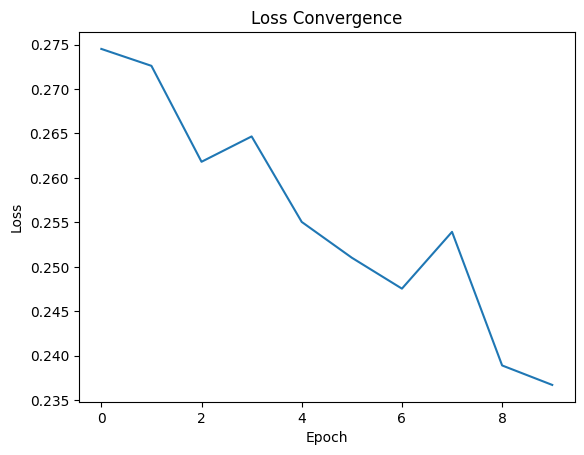

In [62]:
plt.plot(history.history['loss'])
plt.title('Loss Convergence')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

The spiking but downward trend in the loss during training could indicate that the model is learning from the data, but the training process is not smooth. Even with a `Dropout` layer, `val_loss` behavior is an indication that the model is overfitting to the training data. This is addressed with the next set of models (BERT); also why metrics are higher in sample but lower out-of-sample.

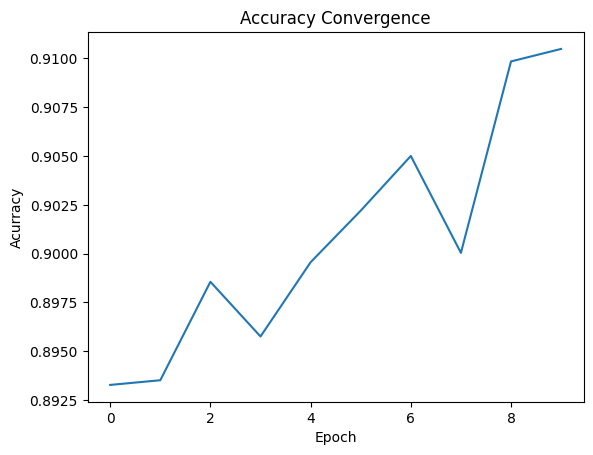

In [65]:
plt.plot(history.history['accuracy'])
plt.title('Accuracy Convergence')
plt.ylabel('Acurracy')
plt.xlabel('Epoch')
plt.show()

## 2. Bias analysis

One way to perform the bias analysis is comparing the predictions from the models on the reviews that contains words related to gender and with the actual labels of those reviews.

In [79]:
# Function to get metrics

def get_metrics(y_trues, y_preds, verbose=True):

  recall = recall_score(y_trues, y_preds) * 100
  precision = precision_score(y_trues, y_preds) * 100
  f1 = f1_score(y_trues, y_preds) * 100

  if verbose:
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1: {f1:.2f}')
     

In [80]:
# Create two subsets of the test data: one containing only reviews that mention male characters, and one containing only reviews that mention female characters

test_data = pd.read_csv(main_path+'test.csv').sample(frac=1).reset_index(drop=True)
X_test = test_data['text']
y_test = test_data['label']

#Since predict_classes is deprecated from TensorFlow 2.6.0 onwards
y_pred = (model.predict(X_test) > 0.5).astype("int32")

male_idxs = [idx for idx, review in enumerate(X_test) if "he" in review.lower() or "his" in review.lower() or "him" in review.lower()]# or "man" in review.lower() or "men" in review.lower()]
female_idxs = [idx for idx, review in enumerate(X_test) if "she" in review.lower() or "her" in review.lower() or "hers" in review.lower()]# or "woman" in review.lower() or "women" in review.lower()]

X_test_male = [X_test[i] for i in male_idxs]
y_test_male = y_test[male_idxs]
y_pred_male = y_pred[male_idxs]

X_test_female = [X_test[i] for i in female_idxs]
y_test_female = y_test[female_idxs]
y_pred_female = y_pred[female_idxs]

# Evaluate the model's performance on each subset separately

print("2LSTM RNN - Performance on reviews mentioning male characters:")
metrics_male = get_metrics(y_test_male, y_pred_male)

print("2LSTM RNN - Performance on reviews mentioning female characters:")
metrics_female = get_metrics(y_test_female, y_pred_female)

782/782 [==============================] - 31s 40ms/step
2LSTM RNN - Performance on reviews mentioning male characters:
Precision: 89.91
Recall: 82.09
F1: 85.82
2LSTM RNN - Performance on reviews mentioning female characters:
Precision: 89.67
Recall: 81.50
F1: 85.39


The performance of various models appears to be better for reviews discussing male characters compared to those discussing female characters, based on overall metrics. This discrepancy may arise from biased data or training processes. If the training data disproportionately features reviews or characters that are male, the models might become more proficient at predicting sentiments for male-centric reviews and characters, leading to improved performance in those cases.